In [7]:
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("./twitter_training.csv")
df.drop(["tweet id", "entity"], inplace=True, axis=1)
df.head()

,sentiment,content
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [9]:
df["sentiment"].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

### Pre processing

In [10]:
lb = LabelEncoder()
df["label_sentiment"] = lb.fit_transform(df["sentiment"])

In [11]:
df.head()

,sentiment,content,label_sentiment
0,Positive,im getting on borderlands and i will murder yo...,3
1,Positive,I am coming to the borders and I will kill you...,3
2,Positive,im getting on borderlands and i will kill you ...,3
3,Positive,im coming on borderlands and i will murder you...,3
4,Positive,im getting on borderlands 2 and i will murder ...,3


In [12]:
df.isnull().sum()

sentiment            0
content            686
label_sentiment      0
dtype: int64

In [13]:
df.dropna(inplace=True)

In [14]:
df.isnull().sum()

sentiment          0
content            0
label_sentiment    0
dtype: int64

In [15]:
lb.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [16]:
df["sentiment"].value_counts()

sentiment
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

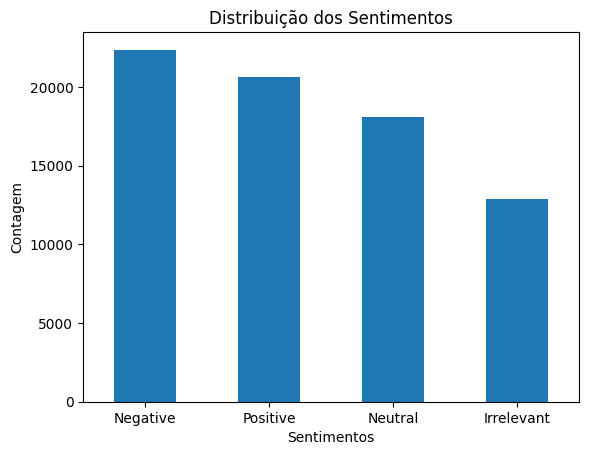

In [17]:
value_counts = df["sentiment"].value_counts()
ax = value_counts.plot(kind='bar')

ax.set_xticklabels(['Negative', 'Positive', 'Neutral', 'Irrelevant'], rotation=0)

plt.title('Distribuição dos Sentimentos')
plt.xlabel('Sentimentos')
plt.ylabel('Contagem')

plt.show()

In [18]:
nltk.download('wordnet')
nltk.download('stopwords')
wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def preprocessing_text(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = text.split()
    text = " ".join([wnl.lemmatize(word) for word in text if not word in stop_words and len(word) >= 3])
    return text.lower()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\janna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
print(preprocessing_text("im getting on borderlands and i will murder you"))

getting borderland murder


In [20]:
df["content"] = df["content"].apply(preprocessing_text)

In [21]:
df.head()

,sentiment,content,label_sentiment
0,Positive,getting borderland murder,3
1,Positive,coming border kill,3
2,Positive,getting borderland kill,3
3,Positive,coming borderland murder,3
4,Positive,getting borderland murder,3


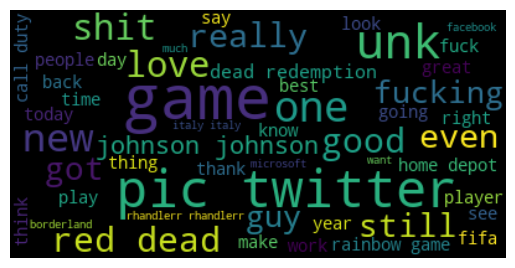

In [22]:
from PIL import Image
from wordcloud import WordCloud

text = " ".join(df["content"])

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="blacK").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
from random import randint

x = randint(0, df.shape[0])

df.iloc[x:x+5, :]

,sentiment,content,label_sentiment
36941,Negative,unk publisher crashed microsoft,1
36942,Irrelevant,nintendo thing company never friendly people c...,0
36943,Irrelevant,nintendo nothing company never friendly people...,0
36944,Irrelevant,nintendo nothing company,0
36945,Irrelevant,nintendo thing company friendly people claim,0


### Modeling

In [24]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [25]:
def get_vocab(X):
    vocab = {'__UNK__': 0}

    for item in X:
        for word in item.split():
            if word not in vocab:
                vocab[word] = len(vocab)
    
    return vocab

vocab = get_vocab(df["content"])

In [26]:
print(len(vocab))

27371


In [27]:
def text_to_tensor(text, unk_token='__UNK__'):
    
    tensor = [0] * 130

    for e, word in enumerate(text.split()):
        if not word in vocab:
            word = unk_token
        
        tensor[e] = vocab[word]
    
    return tensor

In [28]:
m = 0

list_x = df["content"].values

for i in range(df["content"].shape[0]):
    if len(text_to_tensor(list_x[i])) > m:
        m = len(text_to_tensor(list_x[i]))

print(m)

130


In [29]:
X = list(df["content"].apply(text_to_tensor))
y = list(df["label_sentiment"])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
X_train = torch.as_tensor(X_train).to(device)
y_train = torch.as_tensor(y_train).to(device)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)

In [32]:
X_test = torch.as_tensor(X_test).to(device)
y_test = torch.as_tensor(y_test).to(device)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=2, shuffle=True)

In [33]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("train_data length:", len(train_data))

X_train shape: torch.Size([59196, 130])
y_train shape: torch.Size([59196])
train_data length: 59196


In [34]:
def train(model, num_epochs):
    train_loss = []
    train_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
        accuracy = total_correct / total_samples
        train_loss.append(loss.item())
        train_accuracy.append(accuracy * 100)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

In [42]:
def test(model):

    total_correct = 0
    total_samples = 0
    for inputs, labels in test_loader:
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
        
    print(f'Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

### Model 1

In [53]:
class SimpleNLPModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(SimpleNLPModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size) #tam dicionario, tam vetor
        self.fc = nn.Linear(embed_size, num_classes) #tam entrada, tam saida

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = torch.mean(embedded, dim=1)
        out = self.fc(pooled)
        return out

In [54]:
vocab_size = len(vocab) + 1
embed_size = 50
num_classes = df["sentiment"].nunique()

In [55]:
model = SimpleNLPModel(vocab_size, embed_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [56]:
train(model, num_epochs=20)

Epoch 1/20, Loss: 1.4901841878890991, Accuracy: 61.55%
Epoch 2/20, Loss: 0.12497323751449585, Accuracy: 77.36%
Epoch 3/20, Loss: 2.7130284309387207, Accuracy: 82.10%
Epoch 4/20, Loss: 1.0394599437713623, Accuracy: 84.13%
Epoch 5/20, Loss: 0.009534100070595741, Accuracy: 85.45%
Epoch 6/20, Loss: 0.800910472869873, Accuracy: 86.59%
Epoch 7/20, Loss: 0.5219999551773071, Accuracy: 87.23%
Epoch 8/20, Loss: 0.13260938227176666, Accuracy: 87.70%
Epoch 9/20, Loss: 1.3483097553253174, Accuracy: 88.19%
Epoch 10/20, Loss: 0.0019675581716001034, Accuracy: 88.48%
Epoch 11/20, Loss: 0.008706064894795418, Accuracy: 88.83%
Epoch 12/20, Loss: 1.0403271913528442, Accuracy: 89.15%
Epoch 13/20, Loss: 0.00030342742684297264, Accuracy: 89.16%
Epoch 14/20, Loss: 0.148288294672966, Accuracy: 89.41%
Epoch 15/20, Loss: 0.019870439544320107, Accuracy: 89.41%
Epoch 16/20, Loss: 0.0043249898590147495, Accuracy: 89.62%
Epoch 17/20, Loss: 1.1116639375686646, Accuracy: 89.88%
Epoch 18/20, Loss: 0.03236855939030647, A

In [43]:
test(model)

Loss: 2.914051055908203, Accuracy: 85.34%


### Model 2

In [118]:

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1) 
        output = self.fc(lstm_out)
        
        return output

In [119]:
vocab_size = len(vocab) + 1
embed_size = 100
num_classes = df["sentiment"].nunique()
hidden_size = 128
num_layers = 3
dropout = 0.5

In [120]:
lstm_model = LSTMModel(vocab_size, embed_size, num_classes, hidden_size, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [121]:
train(lstm_model, num_epochs=20)

Epoch 1/20, Loss: 0.5558639764785767, Accuracy: 51.26%
Epoch 2/20, Loss: 0.017096195369958878, Accuracy: 73.04%
Epoch 3/20, Loss: 0.0008254027343355119, Accuracy: 82.83%
Epoch 4/20, Loss: 0.495476633310318, Accuracy: 87.64%
Epoch 5/20, Loss: 0.0081260334700346, Accuracy: 90.03%
Epoch 6/20, Loss: 0.0008847080753184855, Accuracy: 91.48%
Epoch 7/20, Loss: 9.726540884003043e-05, Accuracy: 92.39%
Epoch 8/20, Loss: 0.027886031195521355, Accuracy: 93.05%
Epoch 9/20, Loss: 0.0002872755576390773, Accuracy: 93.59%
Epoch 10/20, Loss: 0.024915792047977448, Accuracy: 94.08%
Epoch 11/20, Loss: 0.02863849699497223, Accuracy: 94.48%
Epoch 12/20, Loss: 0.6274543404579163, Accuracy: 94.67%
Epoch 13/20, Loss: 0.03913205862045288, Accuracy: 94.96%
Epoch 14/20, Loss: 0.000327480083797127, Accuracy: 94.96%
Epoch 15/20, Loss: 5.0899776397272944e-05, Accuracy: 95.23%
Epoch 16/20, Loss: 1.7584400177001953, Accuracy: 95.31%
Epoch 17/20, Loss: 0.0009517546277493238, Accuracy: 95.41%
Epoch 18/20, Loss: 5.78135404

In [126]:
test(lstm_model)

Loss: 0.00017854564066510648, Accuracy: 86.89%


### Conceitos

#### Pooling

    Pooling é uma operação comumente usada em redes neurais convolucionais (CNNs) para reduzir a dimensionalidade e agregar informações. No entanto, em redes recorrentes como LSTM, o pooling não é uma prática padrão. A ideia por trás do pooling no seu código era provavelmente tentar reduzir a dimensão da entrada antes de passá-la para a LSTM, mas isso não é necessário e pode ser contraproducente.

#### Squeeze

    Squeeze é uma operação que remove dimensões de tamanho 1 de um tensor. No seu código, squeeze(0) está sendo usado para ajustar as dimensões da saída da LSTM antes de passá-la para a camada totalmente conectada (fc). No entanto, essa abordagem pode causar problemas, como a incompatibilidade de tamanhos de lote que você está vendo.